# Human Centered Design | Assignment 1 | Data Curation

### This notebook is comprised of three sections, which should be run in succession. Each section leverages the ouput of the previous, which are saved as files for future use and reference, and therefore do not need to re-run in subsequent sessions.

### Section 1: API calls for data, write data to files

In this section, we'll be making 5 requests across 2 endpoints to get the relevant data in json payloads, spanning the requested dates.

In [1]:
import json
import requests

Update the header with your information.

In [2]:
headers = {
    'User-Agent': 'https://github.com/castlea',
    'From': 'caleona@uw.edu'
}

Establishing utility function for making API calls and saving the resultant data.

In [3]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

In [4]:
def write_json(parameters, json_object, is_legacy):
    if is_legacy:
        apiname = "pagecounts"
        accesstype = parameters["access-site"]
        firstmonth = parameters["start"][:-4]
        lastmonth = str(int(parameters["end"][:-4]) - 1)
    else:
        apiname = "pageviews"
        accesstype = parameters["access"]
        firstmonth = parameters["start"][:-4]
        lastmonth = str(int(parameters["end"][:-4]) - 1)
    file_name = apiname + "_" + accesstype + "_" + firstmonth + "-" + lastmonth + ".json"
    
    print("Writing " + file_name)
    with open(file_name, "w") as f:
        f.write(json_object)

Make calls to specified endpoint with varied parameters and then write the file.

In [5]:
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

for access_type in ["desktop", "mobile-app", "mobile-web"]:
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access_type,
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2015070100",
                        "end" : "2021090100"}
    monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
    
    write_json(params_pageviews, json.dumps(monthly_pageviews), is_legacy=False)

Writing pageviews_desktop_201507-202108.json
Writing pageviews_mobile-app_201507-202108.json
Writing pageviews_mobile-web_201507-202108.json


In [6]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

for access_type in ["desktop-site", "mobile-site"]:
    params_legacy_pagecounts = {"project" : "en.wikipedia.org",
                                "access-site" : access_type,
                                "granularity" : "monthly",
                                "start" : "2007120100",
                                "end" : "2021090100"}
    monthly_pagecounts = api_call(endpoint_legacy, params_legacy_pagecounts)
    
    write_json(params_legacy_pagecounts, json.dumps(monthly_pagecounts), is_legacy=True)

Writing pagecounts_desktop-site_200712-202108.json
Writing pagecounts_mobile-site_200712-202108.json


### Section 2: Read in persisted json files, generate combined csv

In this section, we will leverage the files written in Section 1 (whether generated in this session or previously) and unpack and restructure the data as a csv table.

In [7]:
import json
import pandas as pd

In [8]:
json_files = ["pageviews_desktop_201507-202108.json", "pageviews_mobile-app_201507-202108.json",
              "pageviews_mobile-web_201507-202108.json", "pagecounts_desktop-site_200712-202108.json",
              "pagecounts_mobile-site_200712-202108.json"]

Establish the structure of the dataframe. To start we will have 6 columns, but will 2 additional ones later on.

In [9]:
df = pd.DataFrame(columns=['year', 'month', 'pagecount_desktop_views', 'pagecount_mobile_views',
                           'pageview_desktop_views', 'pageview_mobile_views'])

Iterate over the list of datapoints in the json object and append views to the correct column for each month and year.

In [10]:
with open(json_files[0], 'r') as f:
    print("Reading " + json_files[0])
    json_object = json.load(f)

for datum in json_object['items']:
    df = df.append({'year':datum["timestamp"][:4], 'month':datum["timestamp"][4:6], 
                    'pageview_desktop_views':datum["views"]}, ignore_index = True)

Reading pageviews_desktop_201507-202108.json


Modify the relevant rows to add the mobile views (combining mobile-app and mobile-web) for each month and year.

In [11]:
with open(json_files[1], 'r') as f:
    print("Reading " + json_files[1])
    json_object = json.load(f)
    
with open(json_files[2], 'r') as f:
    print("Reading " + json_files[2])
    json_object2 = json.load(f)

for datum1, datum2 in zip(json_object['items'], json_object2['items']):
    if datum1["timestamp"] != datum2["timestamp"]:
        print("Oh no, there's been a mistaken assumption!")
    df.loc[((df['year'] == datum1["timestamp"][:4]) & (df['month'] == datum1["timestamp"][4:6])), 
           'pageview_mobile_views'] = datum1["views"] + datum2["views"]

Reading pageviews_mobile-app_201507-202108.json
Reading pageviews_mobile-web_201507-202108.json


Create a new column that combines desktop and mobile views from the pageview endpoint.

In [12]:
df['pageview_all_views'] = df['pageview_desktop_views'] + df['pageview_mobile_views']

Iterate over the list of datapoints in the json object and either append or updates rows with the views, dpending on whether that month and year already exist in the dataframe or not.

In [13]:
with open(json_files[3], 'r') as f:
    print("Reading " + json_files[3])
    json_object = json.load(f)

for datum in json_object['items']:
    if df.loc[((df['year'] == datum["timestamp"][:4]) & (df['month'] == datum["timestamp"][4:6]))].shape[0] == 0:
        df = df.append({'year':datum["timestamp"][:4], 'month':datum["timestamp"][4:6],
                        'pagecount_desktop_views':datum["count"]}, ignore_index = True)
    else:
        df.loc[((df['year'] == datum["timestamp"][:4]) & (df['month'] == datum["timestamp"][4:6])), 
           'pagecount_desktop_views'] = datum["count"]

Reading pagecounts_desktop-site_200712-202108.json


Same as above.

In [14]:
with open(json_files[4], 'r') as f:
    print("Reading " + json_files[4])
    json_object = json.load(f)

for datum in json_object['items']:
    if df.loc[((df['year'] == datum["timestamp"][:4]) & (df['month'] == datum["timestamp"][4:6]))].shape[0] == 0:
        df = df.append({'year':datum["timestamp"][:4], 'month':datum["timestamp"][4:6],
                        'pagecount_mobile_views':datum["count"]}, ignore_index = True)
    else:
        df.loc[((df['year'] == datum["timestamp"][:4]) & (df['month'] == datum["timestamp"][4:6])), 
           'pagecount_mobile_views'] = datum["count"]

Reading pagecounts_mobile-site_200712-202108.json


Create a new column that combines desktop and mobile views from the pagecount endpoint.

In [15]:
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']

When no data is present, replace with zero and sort chronologically to be more natural to read.

In [16]:
df = df.fillna(0).sort_values(by=['year', 'month'], ignore_index=True)

Reorder the columns, to be as expected.

In [17]:
df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
         'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [18]:
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,0,2998331524,0,0,0,0
1,2008,01,0,4930902570,0,0,0,0
2,2008,02,0,4818393763,0,0,0,0
3,2008,03,0,4955405809,0,0,0,0
4,2008,04,0,5159162183,0,0,0,0
...,...,...,...,...,...,...,...,...
160,2021,04,0,0,0,7641809575,2882714492,4759095083
161,2021,05,0,0,0,7800995735,2824416177,4976579558
162,2021,06,0,0,0,7090481783,2505971366,4584510417
163,2021,07,0,0,0,7544493789,2765584368,4778909421


Save the generated table as a csv file with the name en-wikipedia_traffic_200712-202108.csv.

In [19]:
df.to_csv('en-wikipedia_traffic_200712-202108.csv')

### Section 3: Read combined csv data, visualize as line chart

In this section, we will leverage the csv file written in Section 2 (whether generated in this session or previously) and visualize it as a time series.

In [ ]:
import matplotlib.pyplot as plt

In [20]:
new_df = pd.read_csv('en-wikipedia_traffic_200712-202108.csv').drop('Unnamed: 0', axis=1)
new_df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,0,2998331524,0,0,0,0
1,2008,1,0,4930902570,0,0,0,0
2,2008,2,0,4818393763,0,0,0,0
3,2008,3,0,4955405809,0,0,0,0
4,2008,4,0,5159162183,0,0,0,0
...,...,...,...,...,...,...,...,...
160,2021,4,0,0,0,7641809575,2882714492,4759095083
161,2021,5,0,0,0,7800995735,2824416177,4976579558
162,2021,6,0,0,0,7090481783,2505971366,4584510417
163,2021,7,0,0,0,7544493789,2765584368,4778909421


Create a column combing month and year to plot on the x-axis against the 6 count containing columns.

Plot the selected columns from the dataframe, with scaled up figure size, font sizes, and appropriate labels and titles.

Lastly, save the resultant plot as a png and display it.

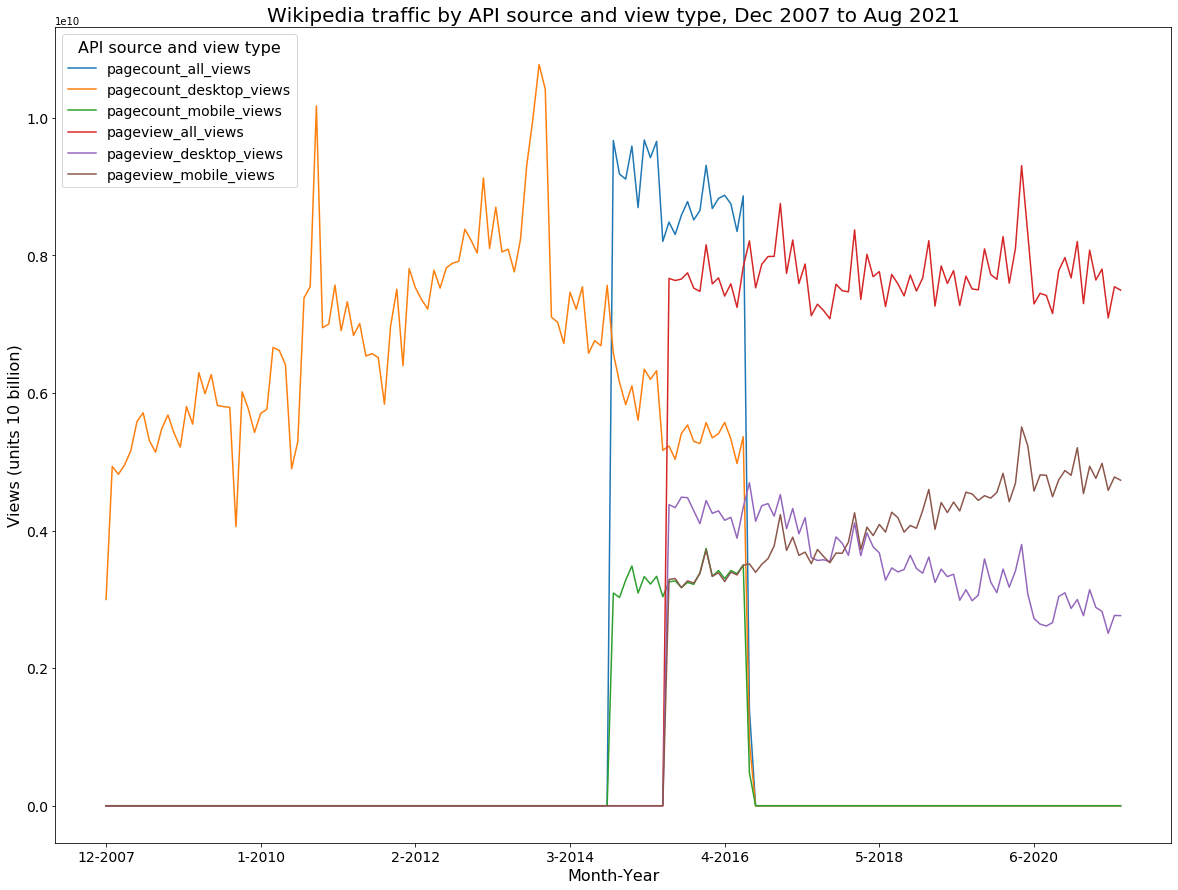

In [22]:
new_df['month-year'] = new_df['month'].astype(str) + '-' + new_df['year'].astype(str)
select_cols = ['month-year', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']

new_df[select_cols].plot(x='month-year', figsize=(20,15))

plt.legend(fontsize='14', title='API source and view type', title_fontsize='16')
plt.xlabel('Month-Year', fontsize='16')
plt.xticks(fontsize='14')
plt.ylabel('Views (units 10 billion)', fontsize='16')
plt.yticks(fontsize='14')
plt.title('Wikipedia traffic by API source and view type, Dec 2007 to Aug 2021', fontsize='20')

plt.savefig('WikipediaViewsTimeSeries.png')    
plt.show()